# Basic Example for Graphical Causal Models

## Step 1: Modeling cause-effect relationships as a structural causal model (SCM)

The first step is to model the cause-effect relationships between variables relevant to our use case. We do that in form of a causal graph. A causal graph is a directed acyclic graph (DAG) where an edge X→Y implies that X causes Y. Statistically, a causal graph encodes the conditional independence relations between variables. Using the [NetworkX](https://networkx.org/) library, we can create causal graphs. In the snippet below, we create a chain X→Y→Z:



In [1]:
import networkx as nx
causal_graph = nx.DiGraph([('X', 'Y'), ('Y', 'Z')])

To answer causal questions using causal graphs, we also have to know the nature of underlying data-generating process of variables. A causal graph by itself, being a diagram, does not have any information about the data-generating process. To introduce this data-generating process, we use an SCM that’s built on top of our causal graph:


In [2]:
from dowhy import gcm
causal_model = gcm.StructuralCausalModel(causal_graph)

At this point we would normally load our dataset. For this introduction, we generate
some synthetic data instead. The API takes data in form of Pandas DataFrames:

In [3]:
import numpy as np, pandas as pd

X = np.random.normal(loc=0, scale=1, size=1000)
Y = 2 * X + np.random.normal(loc=0, scale=1, size=1000)
Z = 3 * Y + np.random.normal(loc=0, scale=1, size=1000)
data = pd.DataFrame(data=dict(X=X, Y=Y, Z=Z))
data.head()

,X,Y,Z
0,0.828540,0.368320,0.178130
1,-0.573015,-0.674695,-1.515167
2,1.578314,2.274793,7.334955
3,-0.302126,-1.514518,-4.689454
4,0.594344,1.231524,3.278236


Note how the columns X, Y, Z correspond to our nodes X, Y, Z in the graph constructed above. We can also see how the
values of X influence the values of Y and how the values of Y influence the values of Z in that data set.

The causal model created above allows us now to assign causal mechanisms to each node in the form of functional causal
models. Here, these mechanism can either be assigned manually if, for instance, prior knowledge about certain causal
relationships are known or they can be assigned automatically using the `auto` module. For the latter,
we simply call:

In [4]:
auto_assignment_summary = gcm.auto.assign_causal_mechanisms(causal_model, data)

Optionally, we can get more insights from the auto assignment process:

In [5]:
print(auto_assignment_summary)

Analyzed 3 nodes.

--- Node: X
Node X is a root node. Assigning 'Empirical Distribution' to the node representing the marginal distribution.

--- Node: Y
Node Y is a non-root node. Assigning 'AdditiveNoiseModel using LinearRegression' to the node.
This represents the causal relationship as Y := f(X) + N.
For the model selection, the following models were evaluated on the mean squared error (MSE) metric:
LinearRegression: 1.001494557677026
Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(include_bias=False)),
                ('linearregression', LinearRegression)]): 1.0029910960009065
HistGradientBoostingRegressor: 1.1935987603503613
Based on the type of causal mechanism, the model with the lowest metric value represents the best choice.

--- Node: Z
Node Z is a non-root node. Assigning 'AdditiveNoiseModel using LinearRegression' to the node.
This represents the causal relationship as Z := f(Y) + N.
For the model selection, the following models were evaluated on the mean square

In case we want to have more control over the assigned mechanisms, we can do this manually as well. For instance, we can
can assign an empirical distribution to the root node X and linear additive noise models to nodes Y and Z:

In [6]:
causal_model.set_causal_mechanism('X', gcm.EmpiricalDistribution())
causal_model.set_causal_mechanism('Y', gcm.AdditiveNoiseModel(gcm.ml.create_linear_regressor()))
causal_model.set_causal_mechanism('Z', gcm.AdditiveNoiseModel(gcm.ml.create_linear_regressor()))

Here, we set node X to follow the empirical distribution we observed (nonparametric) and nodes Y and Z to follow an additive noise model where we explicitly set a linear relationship.

In the real world, the data comes as an opaque stream of values, where we typically don't know how one
variable influences another. The graphical causal models can help us to deconstruct these causal
relationships again, even though we didn't know them before.

## Step 2: Fitting the SCM to the data

With the data at hand and the graph constructed earlier, we can now train the SCM using `fit`:

In [7]:
gcm.fit(causal_model, data)

Fitting causal models:   0%|          | 0/3 [00:00<?, ?it/s]

Fitting causal mechanism of node X:   0%|          | 0/3 [00:00<?, ?it/s]

Fitting causal mechanism of node Y:   0%|          | 0/3 [00:00<?, ?it/s]

Fitting causal mechanism of node Z:   0%|          | 0/3 [00:00<?, ?it/s]

Fitting causal mechanism of node Z: 100%|██████████| 3/3 [00:00<00:00, 428.51it/s]

Fitting means, we learn the generative models of the variables in the SCM according to the data.

Once fitted, we can also obtain more insights into the model performances:

Evaluating causal mechanisms...:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluating causal mechanisms...: 100%|██████████| 3/3 [00:00<00:00, 3196.88it/s]

Test permutations of given graph:   0%|          | 0/6 [00:00<?, ?it/s]

Test permutations of given graph:  33%|███▎      | 2/6 [00:00<00:00, 12.16it/s]

Test permutations of given graph:  67%|██████▋   | 4/6 [00:00<00:00, 12.60it/s]

Test permutations of given graph: 100%|██████████| 6/6 [00:00<00:00, 18.63it/s]

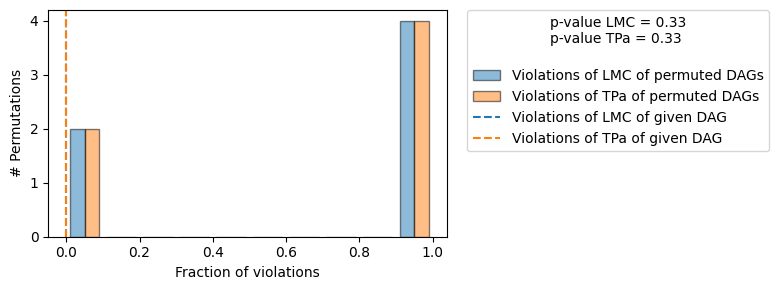

Evaluated the performance of the causal mechanisms and the invertibility assumption of the causal mechanisms and the overall average KL divergence between generated and observed distribution and graph structure. The results are as follows:

==== Evaluation of Causal Mechanisms ====
Root nodes are evaluated based on the KL divergence between the generated and the observed distribution.
Non-root nodes are evaluated based on the (normalized) Continuous Ranked Probability Score (CRPS), which is a generalizes the Mean Absolute Percentage Error to probabilistic predictions. Since the causal mechanisms produce conditional distributions, this should give some insights into their performance and calibration. However, note that many algorithms are still relatively robust against poor model performances.

--- Node X: The KL divergence between generated and observed distribution is 0.10305731074650686.
The estimated KL divergence indicates an overall very good representation of the data distributi

In [8]:
print(gcm.evaluate_causal_model(causal_model, data))

This summary tells us a few things:
- Our models are a good fit.
- The additive noise model assumption was not rejected.
- The generated distribution is very similar to the observed one.
- The causal graph structure was not rejected.

<div class="alert alert-block alert-info">
Note, this evaluation take some significant time depending on the model complexities, graph size and amount of data. For a speed-up, consider changing the evaluation parameters.
</div>

## Step 3: Answering a causal query based on the SCM

The last step, answering a causal question, is our actual goal. E.g. we could ask the question:

> What will happen to the variable Z if I intervene on Y?

This can be done via the `interventional_samples` function. Here’s how:

In [9]:
samples = gcm.interventional_samples(causal_model,
                                     {'Y': lambda y: 2.34 },
                                     num_samples_to_draw=1000)
samples.head()

,X,Y,Z
0,0.623163,2.34,6.724680
1,-0.781923,2.34,7.340677
2,-1.118729,2.34,8.802063
3,0.946871,2.34,6.608137
4,1.628036,2.34,4.745804


This intervention says: "I'll ignore any causal effects of X on Y, and set every value of Y to 2.34." So the distribution of X will remain unchanged, whereas values of Y will be at a fixed value and Z will respond according to its causal model.

<div class="alert alert-block alert-info">
DoWhy offers a wide range of causal questions that can be answered with GCMs. See the user guide or other notebooks for more examples.
</div>